In [1]:
import geopandas as gpd
import pandas as pd
import sqlite3
import contextily as ctx
from fiona.crs import from_epsg

In [28]:
Viajes = pd.read_csv("viajes.csv", sep = ";", encoding = "iso8859_3")
ViajesHogar = Viajes.groupby(['Hogar']).agg(Viajes=('Persona','count')).reset_index()
display(ViajesHogar.head(10))

Hogares = pd.read_csv("Hogares.csv", sep = ";", encoding = "ISO-8859-1")
Hogares = Hogares.merge(ViajesHogar, on='Hogar',how='left')
Hogares['Factor'] = (Hogares['Factor'].str.split()).apply(lambda x: float(x[0].replace(',', '.')))
display(Hogares.head(10))

Hogares['Factor'] = Hogares['Factor'].fillna(0)
Hogares['Viajes'] = Hogares['Viajes'].fillna(0)

Hogares['Factor']=Hogares['Factor'].astype(float)
Hogares['Viajes']=Hogares['Viajes'].astype(int)

Hogares['Total'] = Hogares['Factor']*Hogares['Viajes']
Hogares.describe()
Hogares.sum() 


,Hogar,Viajes
0,100010,7
1,100020,15
2,100030,2
3,100041,10
4,100052,4
5,100061,4
6,100070,9
7,100082,2
8,100090,21
9,100102,6


,Hogar,Sector,Zona,Comuna,DirCoordX,DirCoordY,Fecha,DiaAsig,TipoDia,Temporada,...,NumBicAdulto,NumBicNino,Propiedad,MontoDiv,ImputadoDiv,MontoArr,ImputadoArr,IngresoHogar,Factor,Viajes
0,100010,7,786,BUIN,"335180,8019","6266420,975",14-04-2013,domingo,2,1,...,1,0,2,53000.0,0,100000,0,450845,136.393738,7.0
1,100020,7,785,BUIN,"338410,2114","6265607,141",10-04-2013,miércoles,1,1,...,3,0,1,NaN,0,120000,0,1019369,73.843597,15.0
2,100030,7,791,BUIN,"327863,8248","6257800,086",23-08-2013,viernes,1,1,...,0,0,3,NaN,0,70000,0,80000,180.722809,2.0
3,100041,7,791,BUIN,327864,6257800,23-08-2013,viernes,1,1,...,1,0,1,NaN,0,80000,0,559259,150.379059,10.0
4,100052,7,783,BUIN,"338480,8152","6267296,941",08-08-2013,jueves,1,1,...,0,0,1,NaN,0,117771,1,710309,122.001518,4.0
5,100061,7,783,BUIN,"338520,4611","6267243,59",08-08-2013,jueves,1,1,...,1,1,1,NaN,0,120000,0,415053,122.001518,4.0
6,100070,7,783,BUIN,"338672,2754","6267348,648",08-04-2013,lunes,1,1,...,0,0,1,NaN,0,90000,0,231227,98.045624,9.0
7,100082,7,786,BUIN,"338923,4993","6266488,784",09-08-2013,viernes,1,1,...,0,0,1,NaN,0,140000,0,79133,114.663483,2.0
8,100090,7,785,BUIN,"339472,5195","6262741,68",19-04-2013,viernes,1,1,...,3,1,1,NaN,0,132271,1,1334494,118.012085,21.0
9,100102,7,786,BUIN,"334850,7817","6266124,316",23-08-2013,viernes,1,1,...,2,0,1,NaN,0,138696,1,1543874,108.940498,6.0


Hogar                                                  3525504133
Sector                                                      69792
Zona                                                      8141171
Comuna          BUINBUINBUINBUINBUINBUINBUINBUINBUINBUINBUINBU...
DirCoordX       335180,8019338410,2114327863,8248327864338480,...
DirCoordY       6266420,9756265607,1416257800,0866257800626729...
Fecha           14-04-201310-04-201323-08-201323-08-201308-08-...
DiaAsig         domingomiércolesviernesviernesjuevesjueveslune...
TipoDia                                                     22541
Temporada                                                   22066
NumPer                                                      60054
NumVeh                                                       8887
NumBicAdulto                                                24530
NumBicNino                                                  18696
Propiedad                                                   31612
MontoDiv  

In [32]:
# éste es un archivo preprocesado con datos de la encuesta
travel_survey = (pd.read_csv('stgo-travel-survey-2012.csv.gz')
                 .assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
                 .assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
                 .assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
                )

pd.set_option('display.max_columns', None)
travel_survey.head()
travel_survey.sum() 


Viaje                                                         143148875428428
Hogar                                                             14314885845
Persona                                                         1431488752819
Etapas                                                                  90394
ComunaOrigen                MaipúMaipúLas CondesMaipúÑuñoaMaipúCerrillosMa...
ComunaDestino               MaipúLas CondesMaipúÑuñoaMaipúCerrillosMaipúMa...
ZonaOrigen                                                           27705644
ZonaDestino                                                          27694438
OrigenCoordX                                                      2.57658e+10
OrigenCoordY                                                      4.66863e+11
DestinoCoordX                                                     2.57666e+10
DestinoCoordY                                                     4.66863e+11
PropositoAgregado                                               

In [2]:
Santiago = gpd.read_file('Zonas777-04-04-2014/Shape/Zonas777_V07_04_2014.shp')
Providencia = Santiago.loc[Santiago['COMUNA']=='PROVIDENCIA']

In [5]:
DTPM = pd.read_csv("tablasWeb2019Abril_01_05.MatrizODZonasMediaHora.csv", sep = ";")

In [12]:
DTPM2 = pd.read_csv("tablasWeb2019Abril_01_05.MatrizODComunasMediaHora.csv", sep = ";")
DTPM3 = DTPM2.loc[(DTPM2['ComunaSubida'] != 'PROVIDENCIA') & (DTPM2['ComunaBajada'] == 'PROVIDENCIA')]
DTPM3

,ComunaSubida,ComunaBajada,MediaHora,ViajeLaboralPromedio,Viajes1Etapa,Viajes2Etapas,Viajes3Etapas,Viajes4Etapas,Viajes5oMasEtapas,ViajesUsanMetro,ViajesUsanMetroTren,ViajesSoloMetro,ViajesSoloBus
6,MAIPU,PROVIDENCIA,00:00:00,0.654401,0.654401,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.654401
46,ESTACION CENTRAL,PROVIDENCIA,00:00:00,3.042731,3.042731,0.000000,0.0,0.0,0.0,0.676162,0.0,0.676162,2.366568
100,LO BARNECHEA,PROVIDENCIA,00:00:00,1.218253,0.406084,0.812169,0.0,0.0,0.0,0.000000,0.0,0.000000,1.218253
135,VITACURA,PROVIDENCIA,00:00:00,8.512274,6.809819,1.702455,0.0,0.0,0.0,0.000000,0.0,0.000000,8.512274
189,LA REINA,PROVIDENCIA,00:00:00,0.714546,0.714546,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.714546
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44472,LAS CONDES,PROVIDENCIA,23:30:00,41.188667,41.188667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,41.188667
44524,SANTIAGO,PROVIDENCIA,23:30:00,57.032021,49.720222,7.311797,0.0,0.0,0.0,0.000000,0.0,0.000000,57.032021
44550,QUINTA NORMAL,PROVIDENCIA,23:30:00,0.937686,0.937686,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.937686
44600,PENALOLEN,PROVIDENCIA,23:30:00,0.569655,0.569655,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.569655


In [18]:
DTPM3.describe()

,ViajeLaboralPromedio,Viajes1Etapa,Viajes2Etapas,Viajes3Etapas,Viajes4Etapas,Viajes5oMasEtapas,ViajesUsanMetro,ViajesUsanMetroTren,ViajesSoloMetro,ViajesSoloBus
count,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000,1336.000000
mean,336.116586,248.853619,82.218032,4.960337,0.081592,0.003006,291.923120,0.948018,214.573066,44.193466
std,651.194864,571.898024,157.085251,10.673061,0.201799,0.028250,582.884335,6.868836,510.647288,93.550197
min,0.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,31.922544,5.885685,9.126770,0.288489,0.000000,0.000000,26.628893,0.000000,0.000000,1.320676
50%,116.903942,53.644930,37.270287,1.743410,0.000000,0.000000,90.128899,0.000000,35.579830,8.008340
75%,316.702209,210.442318,96.218491,4.939170,0.000000,0.000000,278.554916,0.000000,187.181515,37.282248
max,6133.041992,5537.728027,1851.058228,119.673607,2.233512,0.292057,5188.633789,105.451279,4733.009277,944.408691


In [14]:
DTPM4 = DTPM3.groupby(['ComunaBajada']).agg(viajes=('ViajeLaboralPromedio','sum')).reset_index()
DTPM4

,ComunaBajada,viajes
0,PROVIDENCIA,449051.75937


In [4]:
DTPM = DTPM.groupby(['Zona777Bajada']).agg(viajes=('ViajeLaboralPromedio','sum')).reset_index()
DTPM.columns = ['ZONA777','VIAJES']
DTPM['ZONA777'] = DTPM['ZONA777'].astype(int)

,ZONA777,VIAJES
0,0,1798.795772
1,1,2850.377501
2,2,1930.186873
3,3,1174.085996
4,4,6020.027293
...,...,...
787,842,185.921347
788,843,906.150274
789,844,2438.466308
790,845,985.511930


In [26]:
df_merge = Providencia.merge(DTPM, on='ZONA777',how='left')

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


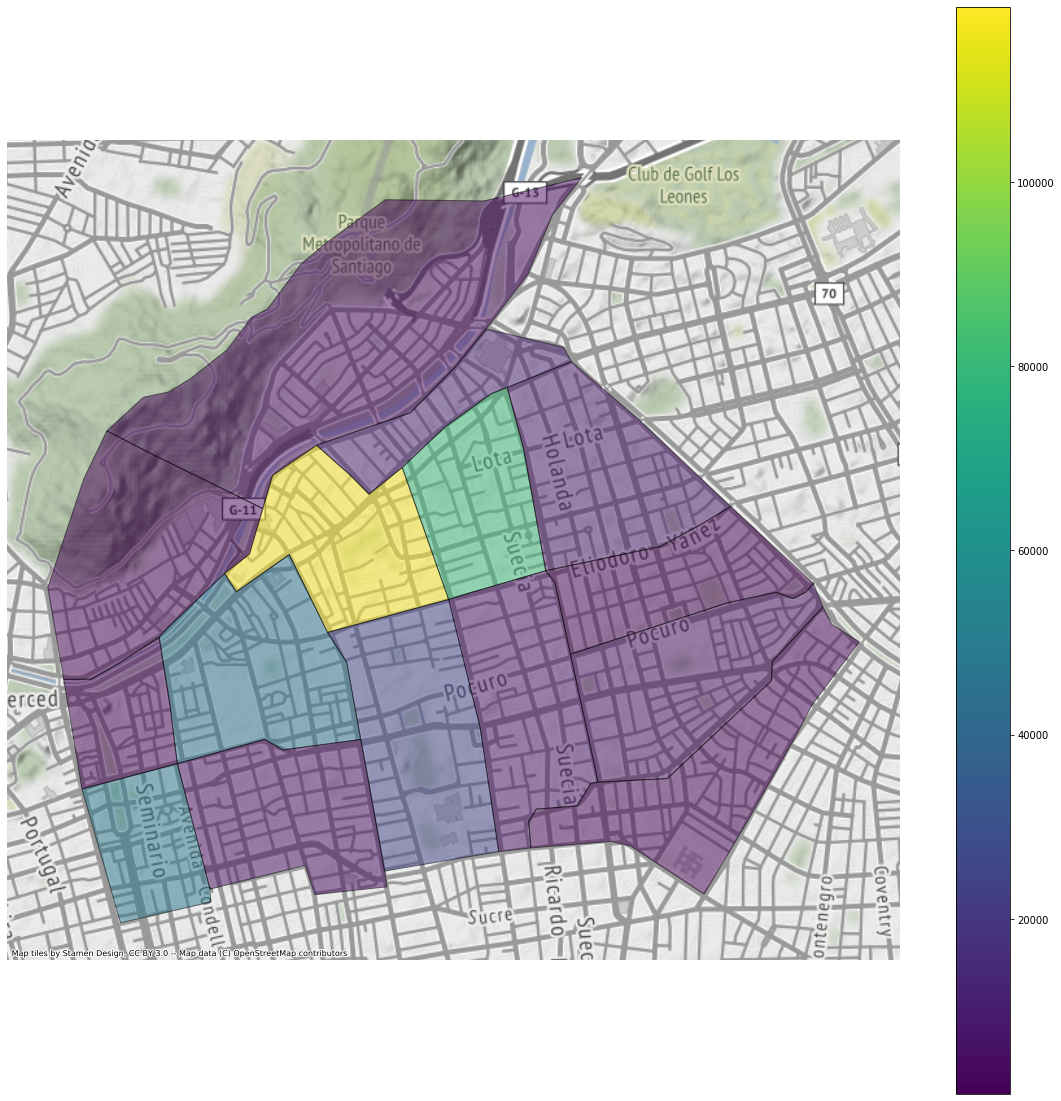

In [14]:
df_merge.crs = from_epsg(4326)
gdf = df_merge.to_crs(epsg=3857) # reproject it in Web mercator
ax = gdf.plot(figsize=(20,20), column = 'VIAJES', legend=True, edgecolor="black", alpha=0.5)
ax.set_axis_off()
ctx.add_basemap(ax)

In [17]:
DTPM = pd.read_csv("tablasWeb2018Oct_08_12.MatrizODZonasMediaHora.csv", sep = ";")
DTPM = DTPM.groupby(['Zona777Bajada']).agg(viajes=('ViajeLaboralPromedio','sum')).reset_index()
DTPM.columns = ['ZONA777','2018']
DTPM['ZONA777'] = DTPM['ZONA777'].astype(int)

In [18]:
df_merge = Providencia.merge(DTPM, on='ZONA777',how='left')

/opt/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


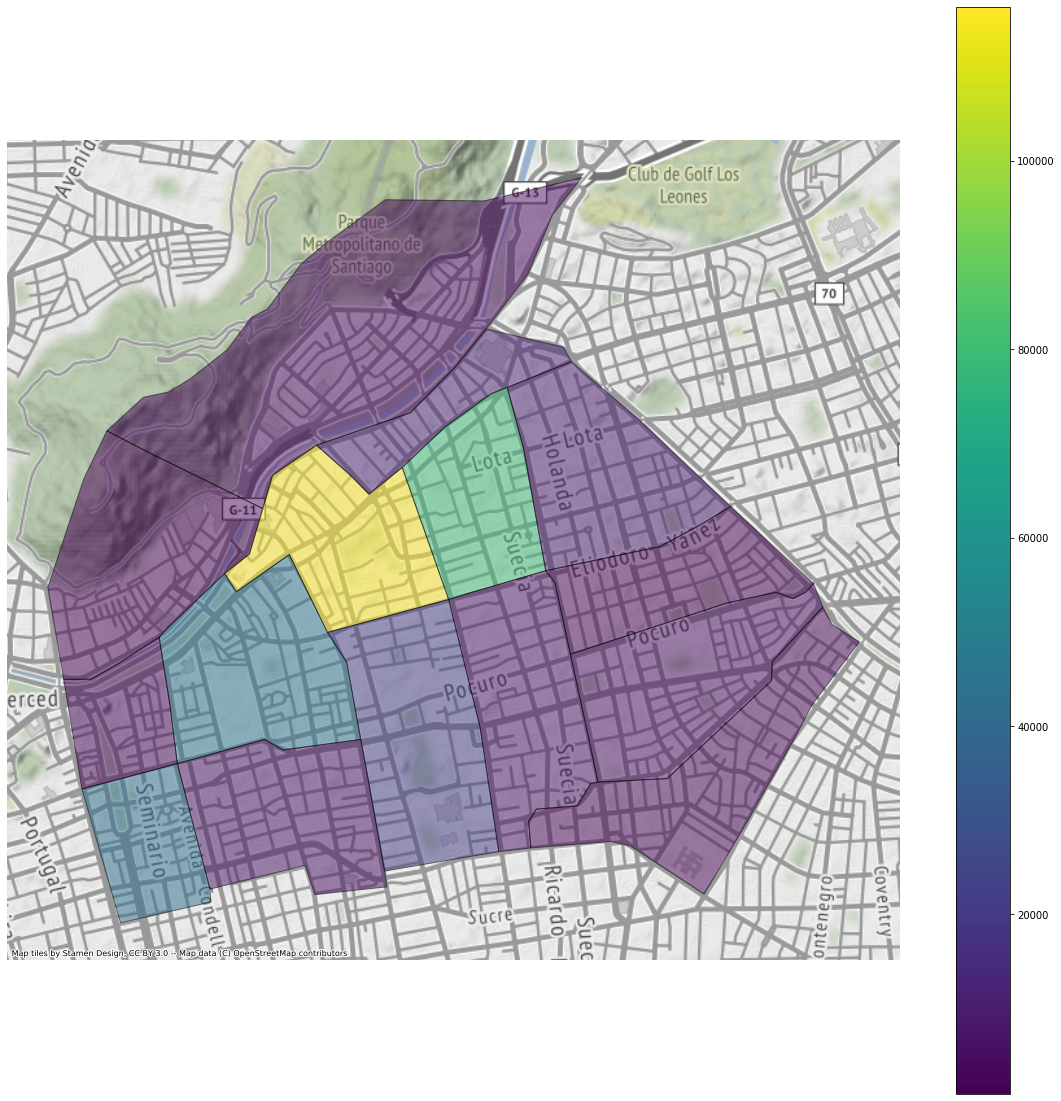

In [19]:
df_merge.crs = from_epsg(4326)
gdf = df_merge.to_crs(epsg=3857) # reproject it in Web mercator
ax = gdf.plot(figsize=(20,20), column = '2018', legend=True, edgecolor="black", alpha=0.5)
ax.set_axis_off()
ctx.add_basemap(ax)

In [27]:
df1 = df_merge.groupby(['COMUNA']).agg(FLOT_TP=('VIAJES','sum')).reset_index()
df1.head()

,COMUNA,FLOT_TP
0,PROVIDENCIA,362922.983394


In [20]:
# éste es un archivo preprocesado con datos de la encuesta
travel_survey = (pd.read_csv('stgo-travel-survey-2012.csv.gz')
                 .assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
                 .assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
                 .assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
                )
travel_survey

,Viaje,Hogar,Persona,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
0,1734310202,173431,17343102,1,Maipú,Maipú,Poniente,Poniente,400,407,...,-70.735153,4,0,0,0,789356,407,22:30:00,23:40:00,70.0
1,1734410101,173441,17344101,2,Maipú,Las Condes,Poniente,Oriente,407,307,...,-70.738205,4,0,0,0,633883,407,13:00:00,14:45:00,105.0
2,1734410102,173441,17344101,2,Las Condes,Maipú,Oriente,Poniente,307,407,...,-70.738205,4,0,0,0,633883,407,22:00:00,23:30:00,90.0
3,1734410301,173441,17344103,2,Maipú,Ñuñoa,Poniente,Oriente,407,437,...,-70.738205,4,0,0,0,633883,407,09:00:00,09:55:00,55.0
4,1734410302,173441,17344103,2,Ñuñoa,Maipú,Oriente,Poniente,437,407,...,-70.738205,4,0,0,0,633883,407,19:00:00,21:30:00,150.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74161,7067910102,706791,70679101,1,Cerro Navia,Cerro Navia,Poniente,Poniente,73,69,...,-70.736540,2,0,0,0,396715,69,12:40:00,12:48:00,8.0
74162,7438130101,743813,74381301,1,La Granja,La Granja,Sur,Sur,244,235,...,-70.621567,2,0,0,0,318005,244,10:30:00,10:45:00,15.0
74163,7438130102,743813,74381301,1,La Granja,La Granja,Sur,Sur,235,244,...,-70.621567,2,0,0,0,318005,244,12:00:00,12:15:00,15.0
74164,7438130201,743813,74381302,1,La Granja,La Granja,Sur,Sur,244,235,...,-70.621567,2,0,0,0,318005,244,10:30:00,10:35:00,5.0


In [21]:
travel_survey.describe()

,Viaje,Hogar,Persona,Etapas,ZonaOrigen,ZonaDestino,OrigenCoordX,OrigenCoordY,DestinoCoordX,DestinoCoordY,...,home_longitude,NumPer,NumVeh,NumBicAdulto,NumBicNino,IngresoHogar,Zona,departure_time,arrival_time,trip_duration
count,7.416600e+04,74166.000000,7.416600e+04,74166.000000,74166.000000,74166.000000,74166.000000,7.416600e+04,74166.000000,7.416600e+04,...,74166.000000,74166.000000,74166.000000,74166.000000,74166.000000,7.416600e+04,74166.000000,74166,74166,74166.000000
mean,1.930115e+09,193011.431721,1.930115e+07,1.218806,373.562603,373.411509,347406.848714,6.294837e+06,347417.954597,6.294843e+06,...,-70.644187,3.834951,0.660451,1.587709,1.223876,8.854564e+05,399.659210,0 days 13:30:21.357495,0 days 14:07:18.335086,36.949627
std,5.227132e+08,52271.324355,5.227132e+06,0.479460,224.411742,224.696818,6070.119002,7.506093e+03,6055.670437,7.500531e+03,...,0.070675,1.627341,0.815413,9.113347,9.421244,9.092340e+05,211.626278,0 days 04:46:01.175300,0 days 04:48:40.216541,94.944268
min,1.033100e+09,103310.000000,1.033100e+07,1.000000,1.000000,1.000000,332943.968800,6.275710e+06,332943.968800,6.275710e+06,...,-70.798737,1.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0 days 00:00:00,0 days 00:00:00,-1439.000000
25%,1.494010e+09,149401.000000,1.494010e+07,1.000000,195.000000,195.000000,343549.835950,6.289618e+06,343580.656300,6.289632e+06,...,-70.696809,3.000000,0.000000,0.000000,0.000000,3.932580e+05,239.000000,0 days 09:00:00,0 days 09:38:00,15.000000
50%,1.911110e+09,191111.000000,1.911110e+07,1.000000,381.000000,380.000000,347513.656300,6.296702e+06,347518.218800,6.296716e+06,...,-70.636292,4.000000,0.000000,0.000000,0.000000,6.500000e+05,391.000000,0 days 13:30:00,0 days 14:00:00,30.000000
75%,2.361900e+09,236190.000000,2.361900e+07,1.000000,545.000000,545.000000,352147.000000,6.300122e+06,352136.906300,6.300117e+06,...,-70.586563,5.000000,1.000000,1.000000,0.000000,1.072410e+06,567.000000,0 days 17:30:00,0 days 18:20:00,60.000000
max,7.438130e+09,743813.000000,7.438130e+07,7.000000,781.000000,781.000000,362849.531300,6.313974e+06,362849.531300,6.313974e+06,...,-70.473881,14.000000,6.000000,99.000000,99.000000,1.480000e+07,781.000000,0 days 23:59:00,0 days 23:59:00,1430.000000


In [27]:
viajes = pd.read_csv("viajes.csv", sep = ";", encoding = "ISO-8859-1")
viajes

,Hogar,Persona,Viaje,Etapas,ComunaOrigen,ComunaDestino,SectorOrigen,SectorDestino,ZonaOrigen,ZonaDestino,...,TiempoMedio,Periodo,MinutosDespues,CuadrasDespues,FactorLaboralNormal,FactorSabadoNormal,FactorDomingoNormal,FactorLaboralEstival,FactorFindesemanaEstival,CódigoTiempo
0,173431,17343102,1734310202,1,94.0,94.0,2.0,2.0,400,407,...,3.0,6.0,6.0,1.0,"1,00000000",NaN,NaN,NaN,NaN,0.0
1,173441,17344101,1734410101,2,94.0,71.0,2.0,3.0,407,307,...,4.0,5.0,5.0,1.0,"1,12721985",NaN,NaN,NaN,NaN,0.0
2,173441,17344101,1734410102,2,71.0,94.0,3.0,2.0,307,407,...,3.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0
3,173441,17344103,1734410301,2,94.0,91.0,2.0,3.0,407,437,...,2.0,5.0,10.0,2.0,"1,12721985",NaN,NaN,NaN,NaN,0.0
4,173441,17344103,1734410302,2,91.0,94.0,3.0,2.0,437,407,...,5.0,4.0,10.0,2.0,"1,05276356",NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113586,743813,74381301,7438130102,1,97.0,97.0,5.0,5.0,235,244,...,1.0,5.0,15.0,4.0,NaN,NaN,"1,48210391",NaN,NaN,NaN
113587,743813,74381302,7438130201,1,97.0,97.0,5.0,5.0,244,235,...,1.0,3.0,15.0,4.0,NaN,NaN,"1,48210391",NaN,NaN,NaN
113588,743813,74381302,7438130202,1,97.0,97.0,5.0,5.0,235,244,...,1.0,5.0,15.0,4.0,NaN,NaN,"1,48210391",NaN,NaN,NaN
113589,743823,74382301,7438230101,1,97.0,97.0,5.0,5.0,235,235,...,1.0,2.0,NaN,NaN,NaN,NaN,"1,14387994",NaN,NaN,NaN


In [35]:
import numpy as np

np.avarenge(Hogares["Viajes"], weights=Hogares["Factor"])

AttributeError: module 'numpy' has no attribute 'averange'

In [36]:
weighted.sum(Hogares["Viajes"], weights=Hogares["Factor"])

NameError: name 'weighted' is not defined

In [37]:
from sklearn.preprocessing import normalize

def visualize_flow(dataframe):
    flujos = (dataframe.groupby(['ComunaOrigen', 'ComunaDestino'])
              .aggregate({'FactorLaboralNormal': 'sum'})
              .reset_index())
    flujos_comunales = pd.pivot_table(flujos, index='ComunaOrigen', columns='ComunaDestino', values='FactorLaboralNormal').fillna(0)
    normalize(flujos_comunales, norm='l1', axis=1, copy=False)
    g = sns.clustermap(flujos_comunales, cmap='inferno_r', square=True, linewidths=1, 
                   metric='cosine', method='ward')
    # esto borra el clustermap
    plt.clf()
    plt.figure(figsize=(16, 16))
    sns.heatmap(g.data2d, cmap='inferno_r', square=True, linewidths=1, cbar_kws={'shrink': 0.4},
               xticklabels=True, yticklabels=True)
    
    

/opt/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:1176: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


ValueError: Method 'ward' requires the distance metric to be Euclidean

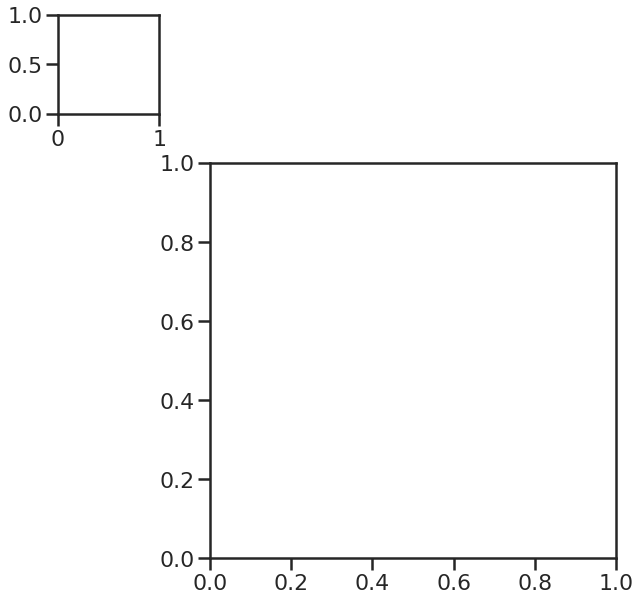

In [44]:
import seaborn as sns
travel_survey = (pd.read_csv('stgo-travel-survey-2012.csv.gz')
                 .assign(departure_time=lambda x: pd.to_timedelta(x['HoraIni']))
                 .assign(arrival_time=lambda x: pd.to_timedelta(x['HoraFin']))
                 .assign(trip_duration=lambda x: (x['arrival_time'] - x['departure_time']) / pd.Timedelta(minutes=1))
                )
visualize_flow(travel_survey[travel_survey['Proposito'].isin(['Al trabajo', 'Al estudio'])])


In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Esto configura la apariencia de los gráficos utilizando configuraciones de seaborn
sns.set(context='poster', style='ticks', palette='inferno', font='Linux Biolinum O')

# Esto es una instrucción de Jupyter que hace que los gráficos se desplieguen en el notebook
%matplotlib inline

In [43]:
# viajes con distancia mayor a 250 metros
travel_survey = travel_survey[(travel_survey.DistManhattan >= 250)
                  # el dataset no incluye el "especifique" así que lo sacamos
                  & (travel_survey.Proposito != 'Otra actividad (especifique)')
                  # estamos analizando la RM así que sacamos viajes fuera de ésta
                  & (~travel_survey.SectorOrigen.isin(['Exterior a RM'])) 
                  & (~travel_survey.Sector.isin(['Exterior a RM']))
                  & (~travel_survey.SectorDestino.isin(['Exterior a RM']))
                  # para los modos de viaje, tampoco se indica qué es "otros"
                  & ~(travel_survey.ModoDifusion == 'Otros')].copy()

In [52]:

travel_survey['PesoLaboral'] = travel_survey['FactorLaboralNormal'] * travel_survey['FactorLaboralNormal']
travel_survey['PesoLaboral'].sample(5)

25747    2.196632
39939    1.000000
8414     1.088002
35307    2.017616
13233    1.000000
Name: PesoLaboral, dtype: float64

In [53]:
flujos = (travel_survey.groupby(['ComunaOrigen', 'ComunaDestino'])
              .aggregate({'PesoLaboral': 'sum'})
              .reset_index())
flujos.sum()

flujos_comunales = pd.pivot_table(flujos, index='ComunaOrigen', columns='ComunaDestino', values='FactorLaboralNormal').fillna(0)
flujos_comunales.sum()

ComunaOrigen     CerrillosCerrillosCerrillosCerrillosCerrillosC...
ComunaDestino    CerrillosCerro NaviaConchalíEl BosqueEstación ...
PesoLaboral                                                77396.4
dtype: object

In [48]:
flujos_comunales = pd.pivot_table(flujos, index='ComunaOrigen', columns='ComunaDestino', values='FactorLaboralNormal').fillna(0)
flujos_comunales.sum()

ComunaDestino
Cerrillos               706.862797
Cerro Navia             698.022091
Colina                    4.649758
Conchalí                817.259813
El Bosque              1236.890083
Estación Central       1331.408375
Huechuraba              697.690491
Independencia           957.703323
La Cisterna             905.542849
La Florida             3730.516892
La Granja              1129.569752
La Pintana             1237.143981
La Reina               1373.493389
Lampa                     4.373907
Las Condes             5422.468707
Lo Barnechea           1059.962952
Lo Espejo               491.110261
Lo Prado                764.735353
Macul                  1279.748195
Maipú                  3759.673431
Pedro Aguirre Cerda     856.693298
Peñalolén              1370.795844
Providencia            4241.257616
Pudahuel               1691.215956
Puente Alto            4148.907587
Quilicura              1592.604796
Quinta Normal           981.572571
Recoleta               1364.883118
Renca 

In [49]:
# Create conda environment, install dependencies on it and activate it
conda create --name aves --file environment.yml
conda activate aves

# Setup pre-commit and pre-push hooks
pre-commit install -t pre-commit
pre-commit install -t pre-push

SyntaxError: invalid syntax (<ipython-input-49-631a231f90be>, line 2)

In [54]:
from aves.data import eod


ModuleNotFoundError: No module named 'aves'